In [1]:
import warnings
import sys
import os

warnings.filterwarnings('ignore')
os.environ["CUDA_VISIBLE_DEVICES"] = '1'
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '.95'
sys.path.append('/mnt/local/data/vtrifonov/prec-learning-Notay-loss/')

In [2]:
import jax.numpy as jnp
from jax import random, vmap, clear_caches, jit
import numpy as np

import optax
from equinox.nn import Conv1d
import matplotlib.pyplot as plt
from functools import partial
from time import perf_counter

from data.dataset import dataset_qtt
from linsolve.cg import ConjGrad
from linsolve.precond import llt_prec_trig_solve, llt_inv_prec
from model import MessagePassing, FullyConnectedNet, PrecNet, ConstantConv1d, MessagePassingWithDot, CorrectionNet

from utils import params_count, asses_cond, iter_per_residual, batch_indices
from data.utils import direc_graph_from_linear_system_sparse
from train import train

plt.rcParams['figure.figsize'] = (11, 7)

# Setup experiment

In [3]:
pde = 'div_k_grad'      # 'poisson', 'div_k_grad'
grid = 32            # 32, 64, 128
variance = .5        # 0.1, 0.5, 1.0 1.5
lhs_type = 'l_ilu0'      # 'fd', 'ilu0', 'ilu1', 'ilu2', 'ict', 'l_ict', 'a_pow'
N_train = 250
N_test = 50

fill_factor = 1     # int
threshold = 1e-4     # float
power = 2            # int
N_valid_CG = 700     # Number of CG iterations for validation in the very end

In [4]:
layer_ = Conv1d         # 'ConstantConv1d' to make a "zero" NN initialization; 'Conv1d' to make a random initialization
loss_type = 'llt'               # 'llt', 'llt-res', 'inv-prec'
loss_reduction = jnp.mean

In [5]:
batch_size = 16
epoch_num = 100
lr = 5e-3
schedule_params = None #[1700, 2001, 300, 1e-1]    # [start, stop, step, decay_size]

In [6]:
# if (loss_type in {'notay', 'llt-res', 'llt-res-norm'} and dataset == 'simple') or (loss_type in {'llt', 'llt-norm'} and dataset == 'krylov'):
#     raise ValueError('Not valid dataset for a chosen loss')

if schedule_params != None:
    assert len(schedule_params) == 4
    
    start, stop, step, decay_size = schedule_params
    steps_per_batch = N_train // batch_size
    start, stop, step = start*steps_per_batch, stop*steps_per_batch, step*steps_per_batch
    lr = optax.piecewise_constant_schedule(
        lr,
        {k: v for k, v in zip(np.arange(start, stop, step), [decay_size, ] * len(jnp.arange(start, stop, step)))}
    )

In [7]:
model_config = {
    'node_enc': {
        'features': [1, 16, 16],
        'N_layers': 2,
        'layer_': layer_
    },
    'edge_enc': {
        'features': [1, 16, 16],
        'N_layers': 2,
        'layer_': layer_
    },
    'edge_dec': {
        'features': [16, 16, 1],
        'N_layers': 2,
        'layer_': layer_
    },
    'mp': {
        'edge_upd': {
            'features': [48, 16, 16],
            'N_layers': 2,
            'layer_': layer_
        },
        'node_upd': {
            'features': [32, 16, 16],
            'N_layers': 2,
            'layer_': layer_
        },
        'mp_rounds': 5
    }
}

# Make dataset

In [8]:
s1 = perf_counter()
A_train, A_pad_train, b_train, u_exact_train, bi_edges_train = dataset_qtt(pde, grid, variance, lhs_type, return_train=True, N_samples=N_train, fill_factor=fill_factor, threshold=threshold, power=power)
A_test, A_pad_test, b_test, u_exact_test, bi_edges_test = dataset_qtt(pde, grid, variance, lhs_type, return_train=False, N_samples=N_test, fill_factor=fill_factor, threshold=threshold, power=power)
print(perf_counter() - s1)

22.3434772901237


In [9]:
A_test, A_pad_test, b_test, u_exact_test, bi_edges_test = A_train, A_pad_train, b_train, u_exact_train, bi_edges_train

In [10]:
# A_pad_train[80, ...].indices[300, :]

In [11]:
# plt.rcParams['figure.figsize'] = (11, 7)
# start, stop = 300, 350
# start_im = 45
# stop_im = start_im + 64

# for j, ind in enumerate(bi_edges_train[80, start:stop, :]):
#     A_loc = A_pad_train[80, ...]
#     A_loc.data = A_loc.data * 0 + 1
#     A_loc.data = A_loc.data.at[ind].set(5)
#     plt.imshow(A_loc[start_im:stop_im, start_im:stop_im].todense())
#     plt.axis(False)
#     plt.show()
    
#     if j == 64: break

# Train model

In [12]:
seed = 42
NodeEncoder = FullyConnectedNet(**model_config['node_enc'], key=random.PRNGKey(seed))
EdgeEncoder = FullyConnectedNet(**model_config['edge_enc'], key=random.PRNGKey(seed))
EdgeDecoder = FullyConnectedNet(**model_config['edge_dec'], key=random.PRNGKey(seed))

mp_rounds = 5
MessagePass = MessagePassing(
    update_edge_fn = FullyConnectedNet(**model_config['mp']['edge_upd'], key=random.PRNGKey(seed)),    
    update_node_fn = FullyConnectedNet(**model_config['mp']['node_upd'], key=random.PRNGKey(seed)),
    mp_rounds=model_config['mp']['mp_rounds']
)

# model = PrecNet(NodeEncoder=NodeEncoder, EdgeEncoder=EdgeEncoder, 
#                 EdgeDecoder=EdgeDecoder, MessagePass=MessagePass)


model = CorrectionNet(NodeEncoder=NodeEncoder, EdgeEncoder=EdgeEncoder, 
                EdgeDecoder=EdgeDecoder, MessagePass=MessagePass)
print(f'Parameter number: {params_count(model)}')

Parameter number: 2754


In [13]:
# data = (X_train, X_test, y_train, y_test)
data = (
    [A_train, A_pad_train, b_train, bi_edges_train, u_exact_train],
    [A_test, A_pad_test, b_test, bi_edges_test, u_exact_test],
    jnp.array([1]), jnp.array([1])
)
train_config = {
    'optimizer': optax.adam,
    'lr': lr,
    'optim_params': {},#{'weight_decay': 1e-8}, 
    'epoch_num': epoch_num,
    'batch_size': batch_size,
    'loss_reduction': loss_reduction
}

In [14]:
s = perf_counter()
model, losses = train(model, data, train_config, loss_name=loss_type, repeat_step=1)
dt = perf_counter() - s

In [15]:
dt

26.725191733799875

In [16]:
print('alpha:', end='')
model.alpha

alpha:

Array([-0.20098874], dtype=float32)

In [17]:
nodes, edges, receivers, senders, _ = direc_graph_from_linear_system_sparse(A_pad_test, b_test)
lhs_nodes, lhs_edges, lhs_receivers, lhs_senders, _ = direc_graph_from_linear_system_sparse(A_test, b_test)

L = vmap(model, in_axes=((0, 0, 0, 0), 0, (0, 0, 0, 0)), out_axes=(0))((nodes, edges, receivers, senders), bi_edges_test, (lhs_nodes, lhs_edges, lhs_receivers, lhs_senders))
del model, data, A_train, A_pad_train, b_train, u_exact_train, bi_edges_train, bi_edges_test
clear_caches()

Final values
  train loss: 294.6123
   test loss: 295.4380
    LLT cond: 1

Minimim test loss `241.0675` at epoch `78`

Minimim test P^(-1)A cond `1` at epoch `0`


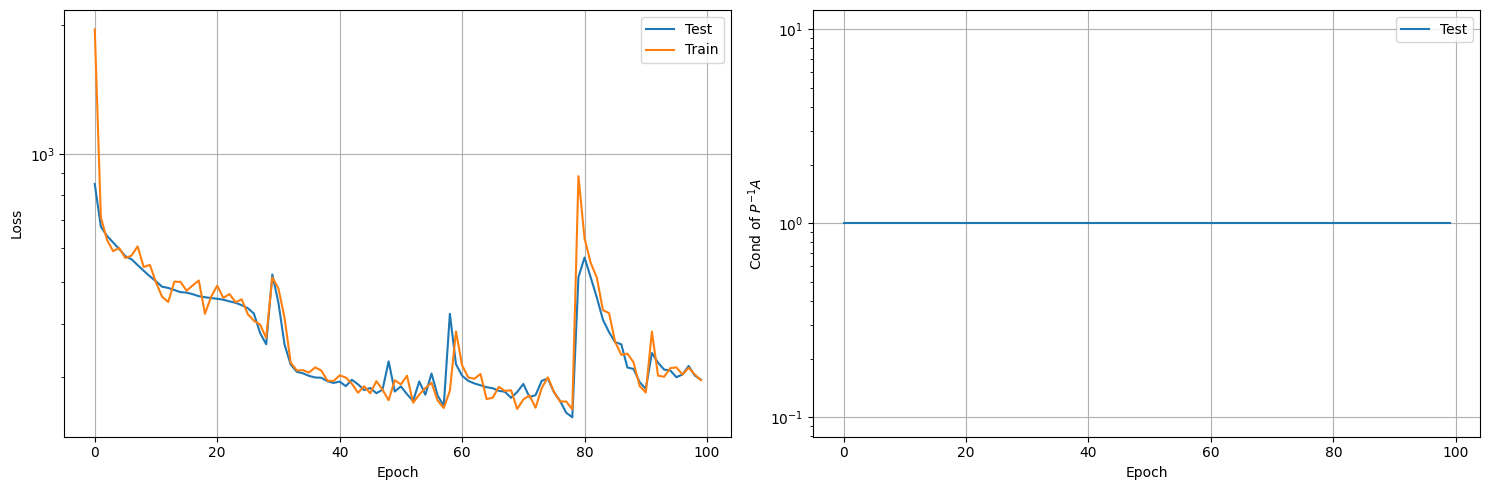

In [18]:
_, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(range(len(losses[0])), losses[1], label='Test')
axes[0].plot(range(len(losses[0])), losses[0], label='Train')
axes[0].legend()
axes[0].set_yscale('log')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss');
axes[0].grid();

axes[1].plot(range(len(losses[0])), losses[2], label='Test')
axes[1].legend()
axes[1].set_yscale('log')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Cond of $P^{-1}A$')
axes[1].grid();

plt.tight_layout()

print(f'Final values\n  train loss: {losses[0][-1]:.4f}\n   test loss: {losses[1][-1]:.4f}\n    LLT cond: {losses[2][-1]:.0f}')
print(f'\nMinimim test loss `{jnp.min(losses[1]).item():.4f}` at epoch `{jnp.argmin(losses[1]).item():.0f}`')
print(f'\nMinimim test P^(-1)A cond `{jnp.min(losses[2]).item():.0f}` at epoch `{jnp.argmin(losses[2]).item():.0f}`')

In [19]:
import ilupp
from utils import jBCOO_to_scipyCSR, asses_cond_with_res
import jax.experimental.sparse as jsparse

cg = partial(ConjGrad, prec_func=partial(llt_prec_trig_solve, L=L[0, ...][None, ...]))
print('Approx cond with constructed:', asses_cond_with_res(A_test[0:1, ...], b_test[0:1, ...], cg))

cg = partial(ConjGrad, prec_func=partial(llt_prec_trig_solve, L=jsparse.BCOO.from_scipy_sparse(ilupp.ichol0(jBCOO_to_scipyCSR(A_test[0, ...])))[None, ...]))
print('Approx cond with IC(0):      ', asses_cond_with_res(A_test[0:1, ...], b_test[0:1, ...], cg))

Approx cond with constructed: 15.449573
Approx cond with IC(0):       22.415003


# Apply model to CG

In [20]:
# Not preconditioned
X_I, R_I = ConjGrad(A_test, b_test, N_iter=N_valid_CG, prec_func=None, seed=42)

In [21]:
if loss_type != 'inv-prec':
    # P = LL^T
    prec = partial(llt_prec_trig_solve, L=L)
else:
    # P^{-1} = LL^T
    prec = partial(llt_inv_prec, L=L)

s_prec = perf_counter()
X_LLT, R_LLT = ConjGrad(A_test, b_test, N_iter=N_valid_CG, prec_func=prec, seed=42)
print(perf_counter() - s_prec)

46.30778047302738


In [22]:
A_pad_test.shape

(250, 1024, 1024)

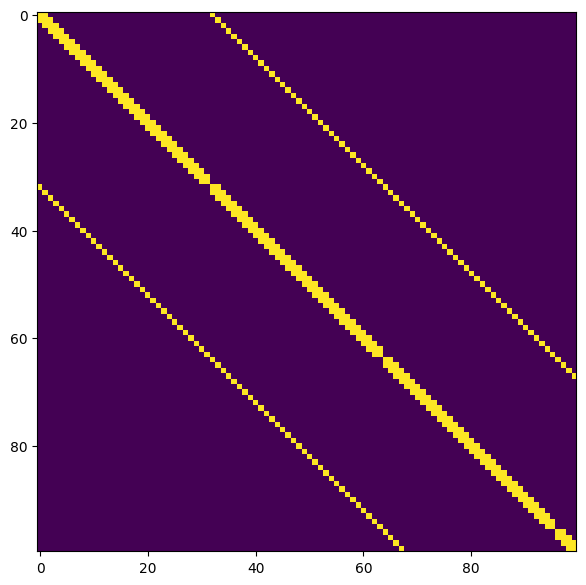

In [23]:
a = A_pad_test[0, :100, :100]
a.data = a.data * 0 + 1
plt.imshow(a.todense())

 CG: {0.001: 213, 1e-06: 282, 1e-09: 365, 1e-12: 439}
PCG: {0.001: 30, 1e-06: 40, 1e-09: 51, 1e-12: 61}


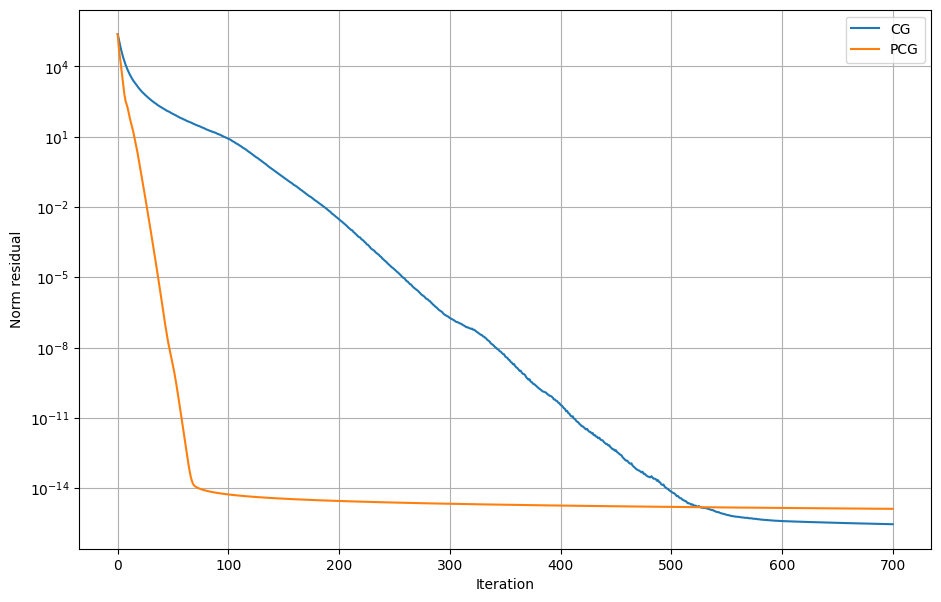

In [24]:
plt.plot(range(R_I.shape[-1]), jnp.linalg.norm(R_I, axis=1).mean(0), label="CG")
plt.plot(range(R_LLT.shape[-1]), jnp.linalg.norm(R_LLT, axis=1).mean(0), label="PCG")

plt.xlabel('Iteration')
plt.ylabel('Norm residual')
plt.legend();
plt.yscale('log')
plt.grid();
    
res_I_dict = iter_per_residual(jnp.linalg.norm(R_I, axis=1).mean(0))
res_LLT_dict = iter_per_residual(jnp.linalg.norm(R_LLT, axis=1).mean(0))
print(' CG:', res_I_dict)
print('PCG:', res_LLT_dict)

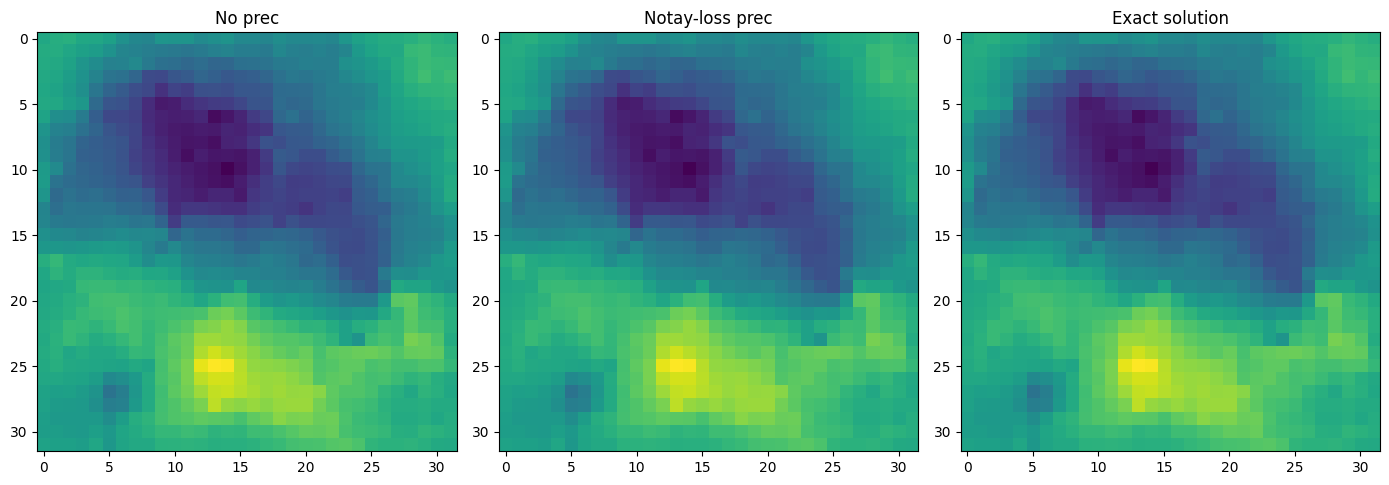

In [25]:
_, axes = plt.subplots(1, 3, figsize=(14, 14))

axes[0].imshow(X_I[0, :, -1].reshape([grid]*2))
axes[1].imshow(X_LLT[0, :, -1].reshape([grid]*2))
axes[2].imshow(u_exact_test[0, :].reshape([grid]*2))

axes[0].set_title('No prec')
axes[1].set_title('Notay-loss prec')
axes[2].set_title('Exact solution')

plt.tight_layout()